In [2]:
!git clone https://github.com/huggingface/diffusers
%cd /content/diffusers/
%pip install .

Cloning into 'diffusers'...
remote: Enumerating objects: 119344, done.
remote: Counting objects: 100% (215/215), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 119344 (delta 171), reused 131 (delta 126), pack-reused 119129 (from 2)
Receiving objects: 100% (119344/119344), 93.55 MiB | 25.88 MiB/s, done.
Resolving deltas: 100% (89475/89475), done.
/content/diffusers
Processing /content/diffusers
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0.37.0.dev0-py3-none-any.whl size=4893405 sha256=0f7bbbd12b834f2f35e2118e0c49fb4b6afd44e10813e947617cbf154e6b9efc
  Stored in directory: /tmp/pip-ephem-wheel-cache-muq776m2/wheels/8a/fc/09/385efb77b455b2fd4a656c950079c93147e1f50ae614e51beb
Successfully built diffusers
  Attempting uninstall: diffusers
    Found existing installation: diffusers 0.36.0
    Uninstalling diffusers-0.36.0:
      Su

In [3]:
%cd /content/diffusers/examples/textual_inversion
%pip install -r requirements.txt
%cd /content/

/content/diffusers/examples/textual_inversion
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.6 MB/s eta 0:00:00
/content


In [4]:
from accelerate.utils import write_basic_config

write_basic_config()

PosixPath('/root/.cache/huggingface/accelerate/default_config.yaml')

To Prepare the images of Licia I used: https://www.birme.net/?target_width=1024&target_height=1024&pica=true

In [5]:
model_id = "sd-legacy/stable-diffusion-v1-5"

In [6]:
dataset_path = "/content/drive/MyDrive/Licia"

In [7]:
textual_inversion_licia_weights_path = "/content/textual_inversion_licia"

In [16]:
from diffusers import StableDiffusionPipeline
import os


if not os.path.exists(textual_inversion_licia_weights_path):
    os.makedirs(textual_inversion_licia_weights_path)

!accelerate launch textual_inversion.py \
  --pretrained_model_name_or_path=$model_id \
  --train_data_dir=$dataset_path \
  --learnable_property="object" \
  --placeholder_token="<licia>" \
  --initializer_token="statue" \
  --resolution=1024 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=4 \
  --max_train_steps=1000 \
  --learning_rate=5.0e-04 \
  --scale_lr \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --output_dir=$textual_inversion_licia_weights_path \
  --mixed_precision fp16



ImportError: peft>=0.17.0 is required for a normal functioning of this module, but found peft==0.7.0.

In [7]:
from google.colab import files
files.download(textual_inversion_licia_weights_path)

FileNotFoundError: Cannot find file: /content/textual_inversion_licia

In [8]:
lora_licia_weights_path = "/content/textual_inversion_licia"

In [14]:
from diffusers import StableDiffusionPipeline
import os


if not os.path.exists(lora_licia_weights_path):
    os.makedirs(lora_licia_weights_path)

%cd /content/diffusers/examples/dreambooth
!accelerate launch train_dreambooth_lora.py \
  --pretrained_model_name_or_path=$model_id \
  --instance_data_dir=$dataset_path \
  --output_dir=$lora_licia_weights_path \
  --instance_prompt="a photo of <Licia> statue" \
  --resolution=1024 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=1 \
  --learning_rate=1e-4 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --max_train_steps=1000 \
  --seed=42 \
  --mixed_precision="fp16"


/content/diffusers/examples/dreambooth
2026-01-21 18:22:43.185771: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769019763.206982    3258 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769019763.213460    3258 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769019763.229443    3258 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769019763.229470    3258 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769019763.229473    3258 computatio

In [16]:
from google.colab import files
files.download("/content/textual_inversion_licia/pytorch_lora_weights.safetensors")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


  0%|          | 0/50 [00:00<?, ?it/s]

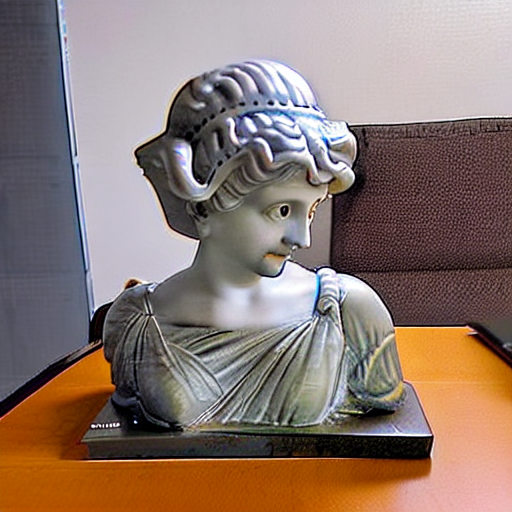

In [24]:
from diffusers import AutoPipelineForText2Image
import torch

pipeline = AutoPipelineForText2Image.from_pretrained(model_id, torch_dtype=torch.float16).to("cuda")
pipeline.load_lora_weights(lora_licia_weights_path, weight_name="pytorch_lora_weights.safetensors")
image = pipeline("A <Licia> statue").images[0]

image

In [26]:
dreambooth_licia_weights_path = "/content/dreambooth_licia"

In [32]:
import torch
import gc
from diffusers import StableDiffusionPipeline
import os

# Free memory from the previous inference cell to avoid OOM
if "pipeline" in globals():
    del pipeline
gc.collect()
torch.cuda.empty_cache()

# Install bitsandbytes for 8-bit optimizer
%pip install bitsandbytes

if not os.path.exists(dreambooth_licia_weights_path):
    os.makedirs(dreambooth_licia_weights_path)

%cd /content/diffusers/examples/dreambooth

!accelerate launch train_dreambooth.py \
  --pretrained_model_name_or_path=$model_id  \
  --instance_data_dir=$dataset_path \
  --output_dir=$dreambooth_licia_weights_path \
  --instance_prompt="a photo of <Licia> statue" \
  --resolution=1024 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=1 \
  --learning_rate=5e-6 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --max_train_steps=1000 \
  --mixed_precision="fp16" \
  --gradient_checkpointing \
  --use_8bit_adam

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 46.0 MB/s eta 0:00:00
/content/diffusers/examples/dreambooth
2026-01-21 18:52:32.678919: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769021552.699251   11147 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769021552.705632   11147 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769021552.722012   11147 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769021552.722039   11147 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking t

In [35]:
import shutil
import os

# 1. Zip the folder
output_filename = "/content/dreambooth_licia"
shutil.make_archive(output_filename, 'zip', "/content/dreambooth_licia")

# 2. Copy the zip file to your Google Drive
# This is much faster and more reliable than downloading through the browser
!cp /content/dreambooth_licia.zip /content/drive/MyDrive/

print("Saved dreambooth_licia.zip to your Google Drive!")

Saved dreambooth_licia.zip to your Google Drive!


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

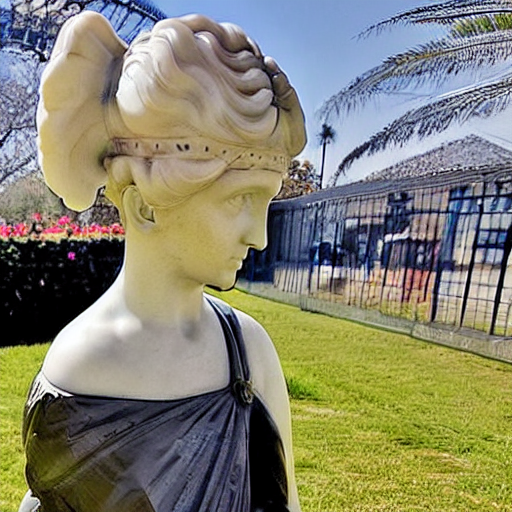

In [38]:
from diffusers import DiffusionPipeline
import torch

pipeline = DiffusionPipeline.from_pretrained("/content/dreambooth_licia", torch_dtype=torch.float16, use_safetensors=True).to("cuda")
image = pipeline("A photo of <Licia> statue", num_inference_steps=50, guidance_scale=7.5).images[0]
image

In [39]:
lora_for_real_licia_weights_path = "/content/lora_for_real_licia_weights"

In [40]:
%cd /content/diffusers/examples/text_to_image/
!accelerate launch --mixed_precision="fp16"  train_text_to_image_lora.py \
  --mixed_precision="fp16" \
  --pretrained_model_name_or_path=$model_id \
  --train_data_dir=$dataset_path \
  --caption_column="caption" \
  --dataloader_num_workers=8 \
  --resolution=1024 \
  --center_crop \
  --random_flip \
  --train_batch_size=1 \
  --gradient_accumulation_steps=4 \
  --max_train_steps=1000 \
  --learning_rate=1e-04 \
  --max_grad_norm=1 \
  --lr_scheduler="cosine" \
  --lr_warmup_steps=0 \
  --output_dir=$lora_for_real_licia_weights_path \
  --checkpointing_steps=500 \
  --seed=1337

/content/diffusers/examples/text_to_image
2026-01-21 20:43:40.107397: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769028220.128711   39414 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769028220.135415   39414 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769028220.152164   39414 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769028220.152195   39414 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769028220.152199   39414 computa

In [41]:
from google.colab import files
files.download("/content/lora_for_real_licia_weights/pytorch_lora_weights.safetensors")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


  0%|          | 0/50 [00:00<?, ?it/s]

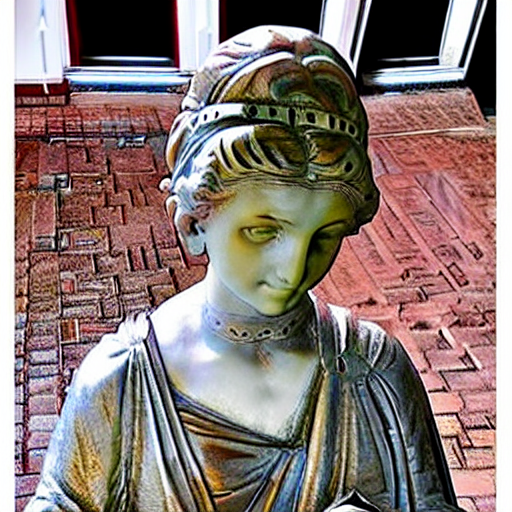

In [51]:
from diffusers import AutoPipelineForText2Image
import torch

pipeline = AutoPipelineForText2Image.from_pretrained(model_id, torch_dtype=torch.float16).to("cuda")
pipeline.load_lora_weights("/content/lora_for_real_licia_weights", weight_name="pytorch_lora_weights.safetensors")
image = pipeline("A photo of :Licia: statue").images[0]
image

In [52]:
dreambooth_lora_hard_weights_path = "dreambooth_lora_hard_weights"

In [55]:
from diffusers import StableDiffusionPipeline
import os


if not os.path.exists(lora_licia_weights_path):
    os.makedirs(lora_licia_weights_path)

%cd /content/diffusers/examples/dreambooth
!accelerate launch train_dreambooth_lora.py \
  --pretrained_model_name_or_path=$model_id \
  --instance_data_dir=$dataset_path \
  --output_dir=$dreambooth_lora_hard_weights_path \
  --instance_prompt="a photo of <Licia> statue" \
  --resolution=1024 \
  --train_batch_size=2 \
  --gradient_accumulation_steps=1 \
  --learning_rate=1e-4 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --max_train_steps=2000 \
  --seed=42 \
  --mixed_precision="fp16"

/content/diffusers/examples/dreambooth
2026-01-21 21:49:42.509098: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769032182.531131   61684 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769032182.537844   61684 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769032182.555353   61684 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769032182.555383   61684 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769032182.555386   61684 computatio

In [60]:
from google.colab import files
files.download("/content/diffusers/examples/dreambooth/dreambooth_lora_hard_weights/pytorch_lora_weights.safetensors")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


  0%|          | 0/50 [00:00<?, ?it/s]

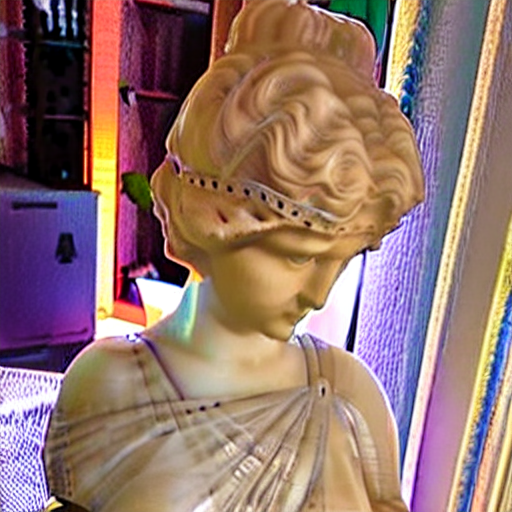

In [59]:
from diffusers import AutoPipelineForText2Image
import torch

pipeline = AutoPipelineForText2Image.from_pretrained(model_id, torch_dtype=torch.float16).to("cuda")
pipeline.load_lora_weights("/content/diffusers/examples/dreambooth/dreambooth_lora_hard_weights", weight_name="pytorch_lora_weights.safetensors")
image = pipeline("A <Licia> statue").images[0]

image